In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

# from warpctc_pytorch import CTCLoss

In [120]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

!ls {PATH}

20_words.csv	 multi_synth_words	paragraphs.tar.gz      words
ascii		 multi_synth_words.csv	synth_words	       words_chars.csv
chars.csv	 multi_synth_words.tgz	synth_words_50000.csv  words.csv
line_labels.csv  paragraph_chars.csv	synth_words.csv        words.tgz
lines		 paragraphs		tmp
lines.tgz	 paragraphs.csv		word_char_ids.csv
models		 paragraphs_df.csv	word_labels.csv


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Synthetic Data

### images

In [94]:
synth_path = PATH/'testing_multi_synth_words'
os.makedirs(synth_path, exist_ok=True)

In [95]:
def create_img(files, fname, sz=None):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = sz[0]
    h = sz[1]
        
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))
    
    max_height = max(heights)
    max_width  = max(widths)
    
    total_height = max_height * h #sum(heights)
    total_width  = max_width  * w

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = 0
    x_offset = 0
    
    images = list(reversed(imgs))
    
    for row in range(h):
        x_offset = 0
        for col in range(w):
            i = images.pop()
            new_im.paste(i, (x_offset,y_offset))
            x_offset += (i.size[0]+50)
        y_offset += max_height

    new_im.save(synth_path/fname)

### pd.read_csv

In [105]:
df = pd.read_csv(f'{PATH}/ascii/words.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df.rename(columns={'value': 'word'}, inplace=True)

In [106]:
len(df)

75597

In [107]:
# remove errors
df = df[df.result != 'err']

In [108]:
# calculate character lengths
lgts = df.word.apply(len)  
df['char_len'] = lgts.astype('int32')

In [109]:
# lots of errors from pd.read_csv
# only keep rows w/ word length < 20
df = df[df.char_len < 20]

In [110]:
df = df.loc[df['char_len'] > 3]

In [111]:
df.head()

,filename,result,word,char_len
0,a01-000u-00-05,ok,Gaitskell,9
1,a01-000u-00-06,ok,from,4
2,a01-000u-01-00,ok,nominating,10
4,a01-000u-01-02,ok,more,4
5,a01-000u-01-03,ok,Labour,6


### manually created df

In [126]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )

In [128]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### Create Data

In [119]:
# !rm -rf {synth_path}

# synth_path = PATH/'testing_multi_synth_words'
# os.makedirs(synth_path, exist_ok=True)

In [116]:
def create_synth_data(num):
    d={}
    for i in range(num):
        res = df.sample(6)
        files = list(map(lambda x: x+'.png', res.filename.values))
        label = ' '.join(res.word.values)

        fname = '{:04d}'.format(i)+'.png'
        create_img(files, fname, (2,3))
        d[fname] = label
    return d

d = create_synth_data(10)
len(d)

10

In [117]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,0000.png,being consulted corporations don't would being
1,0001.png,first Stations some under others treatment
2,0002.png,Jesus planning went went created Scot
3,0003.png,photograph occupying compartment been Liberals...
4,0004.png,near vital spawning when apartheid ancient


### Verify

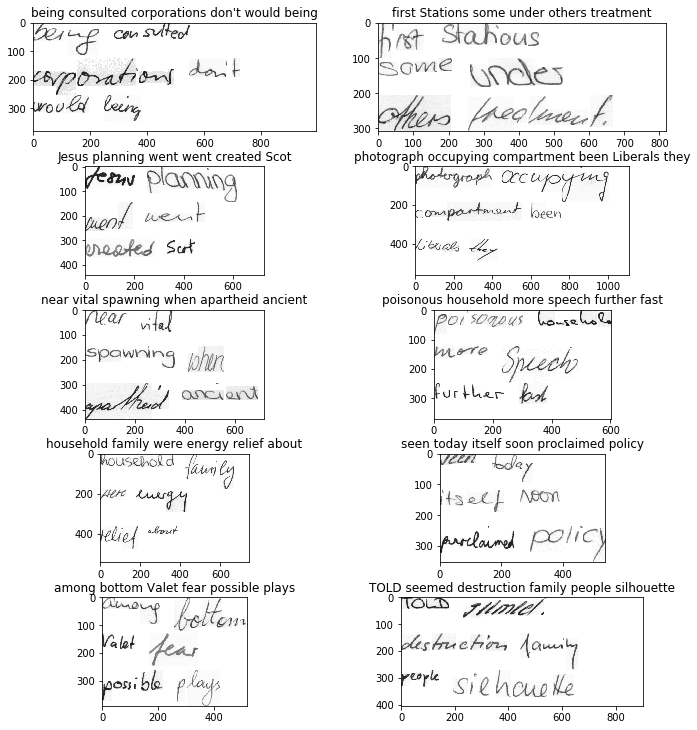

In [118]:
fig, axes = plt.subplots(5,2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(row.labels)
    
plt.tight_layout(pad=0.2)

# Prelim

### Chars

In [113]:
chars = set()
for line in synth.labels:
    chars = chars.union(set(list(line)))
    
len(chars)

71

In [233]:
freq = Counter(char for word in synth.labels for char in word)
freq.most_common(25)

[(' ', 50000),
 ('e', 48515),
 ('t', 29202),
 ('a', 26088),
 ('i', 25911),
 ('r', 25646),
 ('n', 24615),
 ('s', 23796),
 ('o', 22734),
 ('l', 17346),
 ('h', 15649),
 ('d', 14129),
 ('c', 11933),
 ('u', 10707),
 ('m', 10263),
 ('g', 8734),
 ('p', 8360),
 ('y', 6601),
 ('w', 6464),
 ('f', 5658),
 ('b', 5269),
 ('v', 4722),
 ('k', 2566),
 ('-', 908),
 ('T', 906)]

### Numericalize characters

In [234]:
itos = [char for char,count in freq.most_common()]
itos.insert(0, '_pad_')
# leave index 1 as ' '
itos.insert(2, '_eos_')
itos.insert(3, '_unk_')
len(itos)

74

In [235]:
joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [2]) for word in joined_labels])

In [236]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [237]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,0000.png,lace- death four warily considerably without,12 6 15 4 26 1 14 4 6 5 13 1 22 11 16 8 1 21 6...
1,0001.png,food twentieth Western been proved Rhodesia,22 11 11 14 1 5 21 4 9 5 7 4 5 13 1 41 4 10 5 ...
2,0002.png,task choice being longshore which childless,5 6 10 25 1 15 13 11 7 15 4 1 23 4 7 9 18 1 12...
3,0003.png,advisers that GENERAL were false example,6 14 24 7 10 4 8 10 1 5 13 6 5 1 38 32 39 32 4...
4,0004.png,especially That step rolls know been,4 10 19 4 15 7 6 12 12 20 1 27 13 6 5 1 10 5 4...


In [240]:
# np.save(TMP_PATH/'synth_word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'multi_synth_itos.pkl', 'wb'))

### Modify csv/itos to match previous versions

In [146]:
l = []
for i in range(10000):
    l.append('{:04d}'.format(i)+'.png')
l

['0000.png',
 '0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',

In [148]:
# csv = pd.DataFrame(l, columns=['filename'])
csv['words'] = res
csv.head()

,filename,words
0,0000.png,lace- death four warily considerably without
1,0001.png,food twentieth Western been proved Rhodesia
2,0002.png,task choice being longshore which childless
3,0003.png,advisers that GENERAL were false example
4,0004.png,especially That step rolls know been


In [133]:
res = [''.join([itos[int(c)] for c in line.split(' ')[:-1]]) for line in csv.char_ids]
csv['words'] = res
csv.head()

,filename,char_ids,words
0,0000.png,12 6 15 4 26 1 14 4 6 5 13 1 22 11 16 8 1 21 6...,lace- death four warily considerably without
1,0001.png,22 11 11 14 1 5 21 4 9 5 7 4 5 13 1 41 4 10 5 ...,food twentieth Western been proved Rhodesia
2,0002.png,5 6 10 25 1 15 13 11 7 15 4 1 23 4 7 9 18 1 12...,task choice being longshore which childless
3,0003.png,6 14 24 7 10 4 8 10 1 5 13 6 5 1 38 32 39 32 4...,advisers that GENERAL were false example
4,0004.png,4 10 19 4 15 7 6 12 12 20 1 27 13 6 5 1 10 5 4...,especially That step rolls know been


In [134]:
itos2 = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))
itos2[:5]

['_pad_', ' ', '_unk_', '!', '"']

In [135]:
joined_labels = list(csv.words) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos2)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in joined_labels])

In [136]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [149]:
csv['char_ids'] = str_ids
csv.head()

,filename,words,char_ids
0,0000.png,lace- death four warily considerably without,66 55 57 59 13 1 58 59 55 74 62 1 60 69 75 72 ...
1,0001.png,food twentieth Western been proved Rhodesia,60 69 69 58 1 74 77 59 68 74 63 59 74 62 1 51 ...
2,0002.png,task choice being longshore which childless,74 55 73 65 1 57 62 69 63 57 59 1 56 59 63 68 ...
3,0003.png,advisers that GENERAL were false example,55 58 76 63 73 59 72 73 1 74 62 55 74 1 35 33 ...
4,0004.png,especially That step rolls know been,59 73 70 59 57 63 55 66 66 79 1 48 62 55 74 1 ...


### Save to CSV

In [5]:
# ids = np.load(TMP_PATH/'synth_word_ids.npy')
# itos = pickle.load(open(TMP_PATH/'multi_synth_itos.pkl', 'rb'))

# share same itos as show_attend_tell => transfer learning
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

#### full dataset

In [150]:
CSV = PATH/'multi_synth_words.csv'
# CSV = PATH/'synth_words_50000.csv'

# csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,0000.png,66 55 57 59 13 1 58 59 55 74 62 1 60 69 75 72 ...
1,0001.png,60 69 69 58 1 74 77 59 68 74 63 59 74 62 1 51 ...
2,0002.png,74 55 73 65 1 57 62 69 63 57 59 1 56 59 63 68 ...
3,0003.png,55 58 76 63 73 59 72 73 1 74 62 55 74 1 35 33 ...
4,0004.png,59 73 70 59 57 63 55 66 66 79 1 48 62 55 74 1 ...


In [151]:
# length of longest string -> seq_len
csv.char_ids.map(lambda x: len(x.split(' '))).mean()
# max: 73
# mean: 43

42.2004

#### Append to DF

In [43]:
CSV = PATH/'synth_words_50000.csv'

new = pd.concat([csv, synth[['filename', 'char_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

### Get val_idxs

In [152]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### Preprocess (rotate, normalize)

In [156]:
f = resnet34
sz = 128
bs = 30

In [187]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'multi_synth_words', CSV, bs=bs, val_idxs=val_idxs, 
                                    tfms=tfms, continuous=True)

In [188]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [159]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [160]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [161]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)

    #ax.set_axis_off()
#     ax.set_yticks([16, 48, 80, 112], minor=True)
#     ax.set_xticks([16, 48, 80, 112], minor=True)
#     ax.set_yticks([32, 64, 96, 128], minor=False)
#     ax.set_xticks([32, 64, 96, 128], minor=False)
#     ax.yaxis.grid(True, which='both')
#     ax.xaxis.grid(True, which='both')

    if title: ax.set_title(title)
    return ax

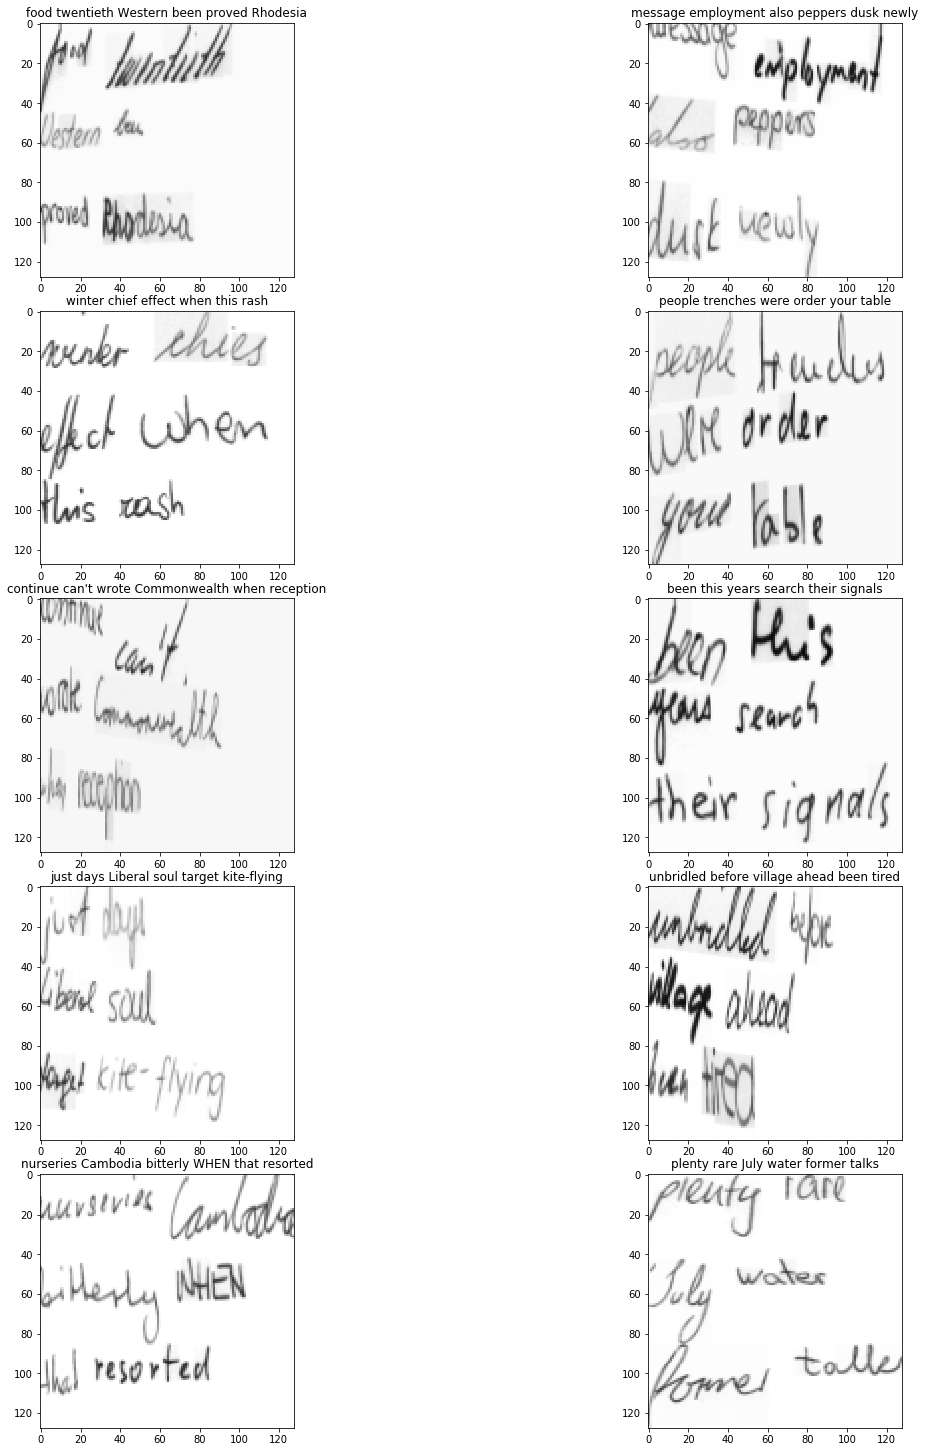

In [162]:
fig, axes = plt.subplots(5,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss fns

In [163]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

# Levenshtein Error Rate

In [28]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [29]:
def error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += cer(t,p)
    return error/bs

# Show, Attend, Tell

### Architecture

In [20]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [21]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [22]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [16]:
# class LinearDecoder(nn.Module):
#     def __init__(self, embed_size, drop=0.3):
#         super().__init__()
        
#         self.linear1 = nn.Linear(embed_size, embed_size)
#         self.linear2 = nn.Linear(embed_size, embed_size)
#         self.drop = nn.Dropout(drop)

#     def forward(self, hidden, context):
#         h = self.linear1(hidden)
#         c = self.linear2(context)
#         g = torch.nn.functional.glu(torch.cat([h,c], 1))
        
#         return self.drop(g)

In [23]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [24]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
#         self.decoder = LinearDecoder(hidden_size)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [165]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 50, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# added Regularization

### Preprocess

In [10]:
f = resnet34
sz = 128
bs = 30

In [11]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [12]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Architecture

In [23]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        net = f(True)
        modules = list(net.children())[:-3]    #(8,8,256)
        self.base = nn.Sequential(*modules)

        #mlp
        self.drop = nn.Dropout(0.4)
        self.linear1 = nn.Linear(256, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)    
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [14]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [15]:
class WeightDrop(torch.nn.Module):
    def __init__(self, module, dropout=0.5, weights=['weight_hh_l0']):
        super().__init__()
        self.module,self.weights,self.dropout = module,weights,dropout
        self._setup()

    def _setup(self):
        if isinstance(self.module, torch.nn.RNNBase):
            self.module.flatten_parameters = noop
            
        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            if hasattr(self.module, name_w):
                delattr(self.module, name_w)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

In [24]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers):
        super().__init__()
        
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, bidirectional=False)#, dropout=0.3)
#         self.rnn = WeightDrop(self.rnn)
        
        # Attention Layers
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, prev_embed, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention

        _, h = self.rnn(context.unsqueeze(0), hidden.unsqueeze(0))  # replace w/ linear layers
        
        return h.squeeze(0), context, a

In [25]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)    # using previous embedding instead of previous input vector
        b = self.w1(hidden)
        c = self.w2(context)
        out = self.drop(torch.cat([a,b,c], 1))
        
        return self.w3(out)

In [17]:
# def dropout_mask(x, sz, dropout):
#     return x.new(*sz).bernoulli_(1-dropout)/(1-dropout)

# class LockedDropout(nn.Module):
#     def __init__(self, p=0.65):
#         super().__init__()
#         self.p=p

#     def forward(self, x):
#         if not self.training or not self.p: return x
#         m = dropout_mask(x.data, x.size(), self.p)
#         return Variable(m, requires_grad=False) * x

In [34]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, dropout=0.4):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.initrange = 0.1
        
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(0.1)
        self.embed.weight.data.uniform_(-self.initrange, self.initrange)

        self.output  = DeepOutputLayer(hidden_size, vocab_size, dropout)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, enc_h = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        hidden = enc_h
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            hidden, context, a = self.decoder(prev, hidden, feats)
            attns.append(a)
            out = self.output(prev, hidden, context)
            res.append(out)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [ ]:
# def seq2seq_reg(output, xtra, loss, alpha=2, beta=1):
#     # Activiation Regularization
#     if alpha: loss = loss + sum(alpha * dropped_rnn_h.pow(2).mean() for dropped_rnn_h in dropped_rnn_hs[-1:])
#     # Temporal Activation Regularization (slowness)
#     if beta: loss = loss + sum(beta * (rnn_h[1:] - rnn_h[:-1]).pow(2).mean() for rnn_h in rnn_hs[-1:])
    
    
#     hs,dropped_hs = xtra
#     if alpha:  # Activation Regularization
#         loss = loss + (alpha * dropped_hs[-1].pow(2).mean()).sum()
#     if beta:   # Temporal Activation Regularization (slowness)
#         h = hs[-1]
#         if len(h)>1: loss = loss + (beta * (h[1:] - h[:-1]).pow(2).mean()).sum()
#     return loss

In [35]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 50, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

# learn.reg_fn = seq2seq_reg
# learn.reg_fn.alpha = 2
# learn.reg_fn.beta = 1

# Finer-grained attention - Resnet50

### Preprocess

In [62]:
f = resnet50
sz = 128
bs = 30

In [63]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [64]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Architecture

In [65]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        net = f(True)
        modules = list(net.children())[:-4]    #([30, 512, 16, 16])
        self.base = nn.Sequential(*modules)

        #mlp
        self.drop = nn.Dropout(0.5)
        self.linear1 = nn.Linear(512, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
                
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [66]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [67]:
class WeightDrop(torch.nn.Module):
    def __init__(self, module, dropout=0.5, weights=['weight_hh_l0']):
        super().__init__()
        self.module,self.weights,self.dropout = module,weights,dropout
        self._setup()

    def _setup(self):
        if isinstance(self.module, torch.nn.RNNBase):
            self.module.flatten_parameters = noop
            
        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            if hasattr(self.module, name_w):
                delattr(self.module, name_w)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

In [68]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers):
        super().__init__()
        
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers, bidirectional=False)#, dropout=0.3)
        self.rnn = WeightDrop(self.dec_rnn)
        
        # Attention Layers
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, prev_embed, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _, h = self.rnn(context.unsqueeze(0), hidden.unsqueeze(0))  # replace w/ linear layers
        
        return h.squeeze(0), context, a

In [69]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)    # using previous embedding instead of previous input vector
        b = self.w1(hidden)
        c = self.w2(context)
        out = self.drop(torch.cat([a,b,c], 1))
        
        return self.w3(out)

In [17]:
# def dropout_mask(x, sz, dropout):
#     return x.new(*sz).bernoulli_(1-dropout)/(1-dropout)

# class LockedDropout(nn.Module):
#     def __init__(self, p=0.65):
#         super().__init__()
#         self.p=p

#     def forward(self, x):
#         if not self.training or not self.p: return x
#         m = dropout_mask(x.data, x.size(), self.p)
#         return Variable(m, requires_grad=False) * x

In [70]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, dropout=0.5):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.initrange = 0.1
        
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(dropout)
        self.embed.weight.data.uniform_(-self.initrange, self.initrange)

        self.output  = DeepOutputLayer(hidden_size, vocab_size, dropout)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, enc_h = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        hidden = enc_h
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            hidden, context, a = self.decoder(prev, hidden, feats)
            attns.append(a)
            out = self.output(prev, hidden, context)
            res.append(out)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [71]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(512, len(itos), 50, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

 50%|████▉     | 141/284 [00:47<00:48,  2.96it/s, loss=342] 

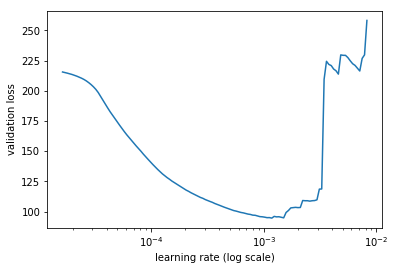

In [54]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

# Training

sz|em_sz|bs|1 epoch|6 epoch|16 epoch|21 epoch|31 epoch|41 epoch
--|-----|--|-------|-------|--------|--------|--------|--------
200|256|30|136.71|131.86|114.97|-|-|-
 - | - |- |0.86|0.80|0.67
256| - | - | - | - | - | 99.63 | 84.395193 | 76.512565
256| - | - | - | - | - | 0.57 | 0.42 | 0.32

In [183]:
lr=1e-3
learn.fit(lr, 1, cycle_len=1)
# vanilla
# 136.716545 0.869386

# preloading 3x1 weights
# 99.874218  0.594965

epoch      trn_loss   val_loss   char_error_rate           
    0      105.069989 99.874218  0.594965  



[99.87421813964843, 0.594964872407878]

In [184]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr=(10, 4))
# vanilla
# 132.80176  131.863912  0.808793 

# preloading 3x1 weights
# 86.732118  92.116078  0.497685

epoch      trn_loss   val_loss   char_error_rate           
    0      100.735105 96.602436  0.559786  
    1      96.225177  93.611522  0.541799                   
    2      92.373749  92.042253  0.517691                   
    3      89.154979  91.752008  0.501054                   
    4      86.732118  92.116078  0.497685                   



[92.11607772827148, 0.49768470404665266]

In [33]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))
# vanilla
# 115.391809 114.97687  0.673306

epoch      trn_loss   val_loss   char_error_rate           
    0      131.163149 130.673215 0.776042  
    1      131.003323 129.395992 0.764182                  
    2      129.526969 128.725048 0.761507                  
    3      128.765353 127.721173 0.755929                  
    4      127.769132 126.09784  0.740478                  
    5      125.878682 124.774431 0.748479                  
    6      123.701167 121.935554 0.716089                  
    7      120.865392 119.592112 0.707619                  
    8      118.274451 117.219771 0.696522                  
    9      115.391809 114.97687  0.673306                  



[114.97686950683594, 0.6733063989712456]

In [185]:
learn.save('3x2_128_preloaded_cer50')
# learn.save('multi_synth_16epochs')

### update saved model parameter names

In [51]:
sd = torch.load(PATH/'models/50000_deep_concat_14epochs.h5', map_location=lambda storage, loc: storage)

In [54]:
sd["attention.attn_v"] = sd.pop("decoder.attn_v")
sd["attention.attn_1.weight"] = sd.pop("decoder.attn_1.weight")
sd["attention.attn_1.bias"] = sd.pop("decoder.attn_1.bias")
sd["attention.attn_2.weight"] = sd.pop("decoder.attn_2.weight")
sd["attention.attn_2.bias"] = sd.pop("decoder.attn_2.bias")
sd["decoder.rnn.weight_ih_l0"] = sd.pop("decoder.dec_rnn.weight_ih_l0")
sd["decoder.rnn.weight_hh_l0"] = sd.pop("decoder.dec_rnn.weight_hh_l0")
sd["decoder.rnn.bias_ih_l0"] = sd.pop("decoder.dec_rnn.bias_ih_l0")
sd["decoder.rnn.bias_hh_l0"] = sd.pop("decoder.dec_rnn.bias_hh_l0")

In [55]:
torch.save(sd, PATH/'models/50000_deep_concat_14epochs_mod.h5')

In [166]:
learn.load('50000_deep_concat_14epochs_mod')   # show_attend_tell 3x1 synth words

## Increase data size

In [186]:
# resize data
sz = 256

# NOTE: re-run preprocessing cells after changing this

In [189]:
learn.set_data(data)

In [190]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr=(10, 4))
# vanilla
# 100.503429 99.639416  0.57183

# preloading 3x1 weights
# 52.448398  55.614853  0.236137

epoch      trn_loss   val_loss   char_error_rate            
    0      69.453592  62.868943  0.337165  
    1      62.719914  58.27796   0.29334                    
    2      57.718084  56.047147  0.268812                   
    3      54.300116  54.346611  0.247935                   
    4      52.448398  55.614853  0.236137                   



[55.614852600097656, 0.2361370208231086]

In [191]:
learn.save('3x2_256_preloaded_cer23')
# learn.save('256_multi_synth_21epochs')

In [68]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))
# vanilla
# 73.640913  84.395193  0.416838

epoch      trn_loss   val_loss   char_error_rate            
    0      96.896304  97.197401  0.549884  
    1      93.915499  96.241492  0.533602                   
    2      90.566493  93.035763  0.519517                   
    3      87.280741  91.61761   0.502912                   
    4      84.80345   90.023858  0.4846                     
    5      81.998173  89.013988  0.465966                   
    6      79.581904  88.312173  0.460483                   
    7      77.772685  86.308966  0.447388                   
    8      75.608696  85.036784  0.429607                   
    9      73.640913  84.395193  0.416838                   



[84.39519287109376, 0.41683790064652637]

In [69]:
learn.save('256_multi_synth_31epochs')

In [70]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))
# vanilla
# 57.173106  76.512565  0.31721

epoch      trn_loss   val_loss   char_error_rate            
    0      71.943404  82.140365  0.405925  
    1      69.495107  82.218144  0.393748                   
    2      67.26007   81.081586  0.379274                   
    3      66.389284  80.321962  0.365812                   
    4      64.702705  78.772724  0.366751                   
    5      64.122691  78.196216  0.35374                    
    6      61.135725  78.377035  0.343291                   
    7      59.731121  77.378957  0.331724                   
    8      59.690751  78.056312  0.324922                   
    9      57.173106  76.512565  0.31721                    



[76.51256538391114, 0.3172099898886025]

In [71]:
learn.save('256_multi_synth_41epochs')

# Results

In [192]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([sl, 256, bs])
res = torch.argmax(preds, dim=-1)

In [193]:
seq2seq_loss(preds, y)

tensor(52.6251, device='cuda:0', grad_fn=<DivBackward0>)

In [169]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [194]:
for i in range(10):
    print(label_text(res[:,i]))

food teenttith Dlster  been proved  hodesia
message enppbymett atoo eepprrs dust  ewly
winter chies effect whee this rash
people truches were order youe  able
continne  an't worte  omowwwetth  her  eeeepin
been this yeass search their iggnals
just days liberrd soul taree titrffriing
unbridleed befree illaae aheaa beeenttra
nursevies aabbodid bitteely HHER  tha  essrttd
plenty rare Soly water foomr taller


## Images

In [171]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


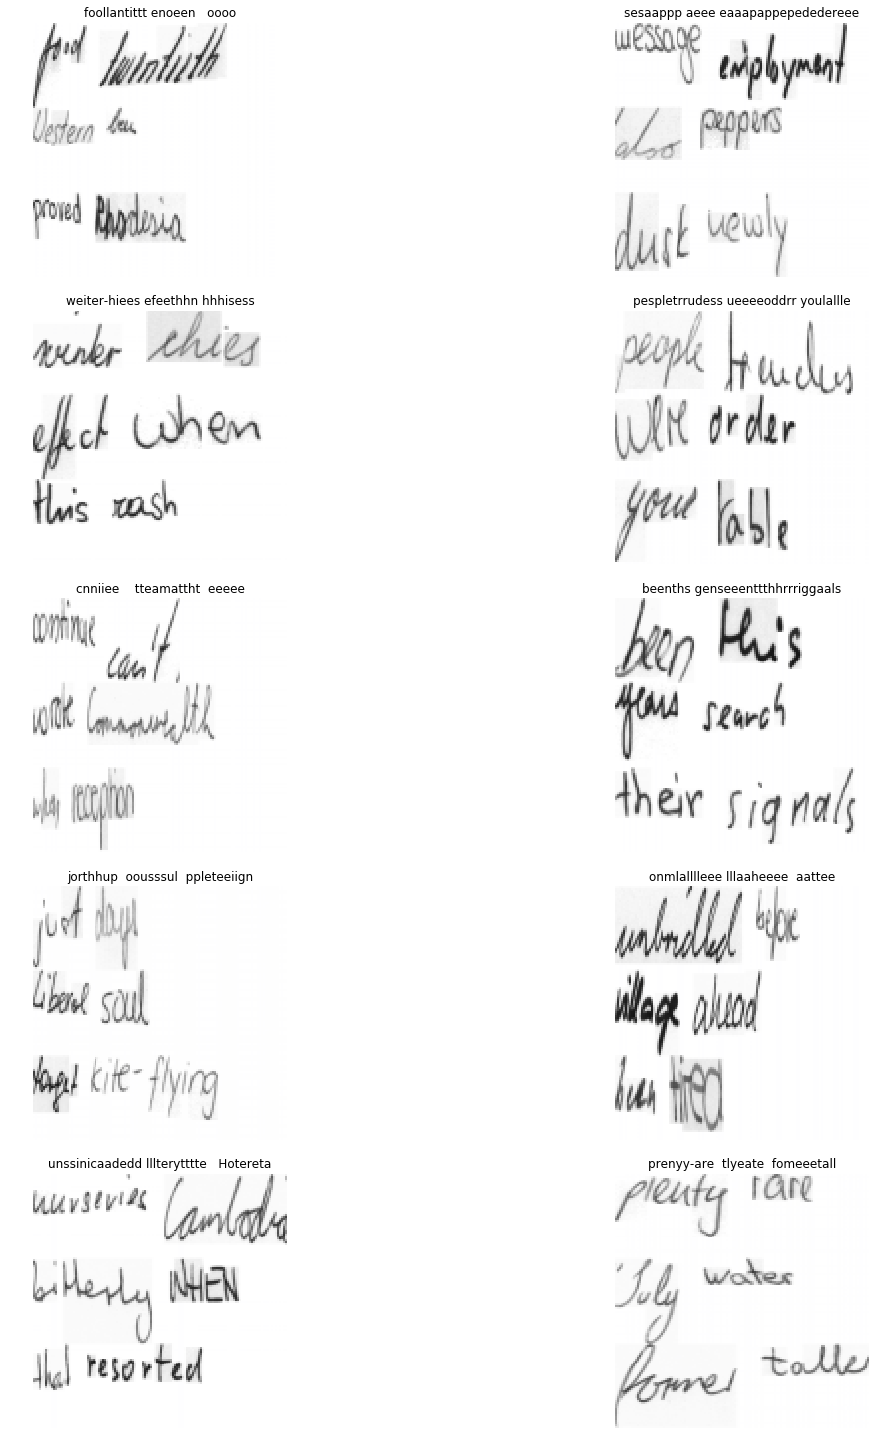

In [172]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(5,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

## Attention

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


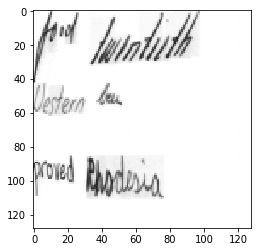

In [195]:
plt.imshow(imgs[0])

In [199]:
def scale_attn_to_img(att):
    num = sz // 16
    a = att.reshape(num,num)
    return np.repeat(np.repeat(a,num, axis=0), num, axis=1)

In [197]:
idx  = 0
img  = imgs[idx]
pred = res[:,idx]
attn = to_np(attns[:,:,idx])  # first batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

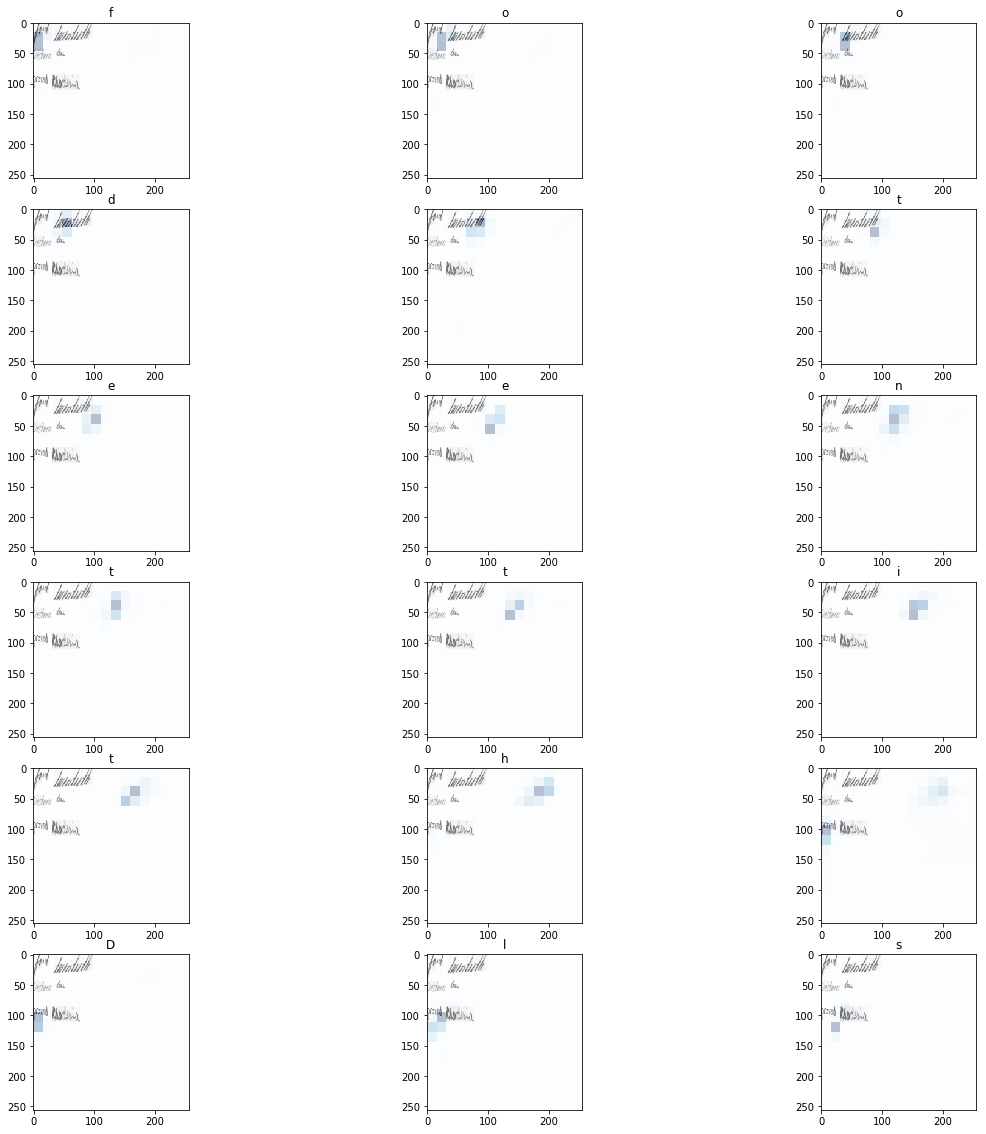

In [200]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
#     ax.plot(attn[i])
    a = scale_attn_to_img(attn[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[pred[i].item()])